Imports and setup

In [1]:
import pickle
import numpy as np
from rdkit import Chem
import rdkit.Chem.QED
import torch

from coati.models.io.coati import load_e3gnn_smiles_clip_e2e

# set your device
DEVICE = torch.device("cuda:0")

Load model

In [2]:
# Model parameters are pulled from the url and stored in a local models/ dir.
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url="s3://terray-public/models/e3gnn_smiles_clip_e2e_1685977071_1686087379.pkl",
)

Loading model from s3://terray-public/models/e3gnn_smiles_clip_e2e_1685977071_1686087379.pkl
Loading tokenizer may from s3://terray-public/models/e3gnn_smiles_clip_e2e_1685977071_1686087379.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
22235904 params frozen!


Random molecule generation

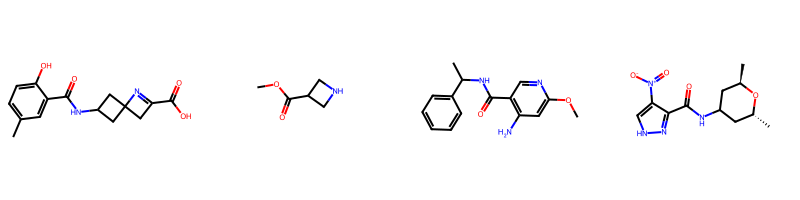

In [3]:
# Generate 5 random molecules likely to come from the Chembl dataset.
likely_chembl = encoder.complete_batch(
    # prefix to initialize the generation: Chembl-like smiles strings
    prefixes=["[SET][chembl_mols][SMILES]" for _ in range(5)],
    # see examples/tokenizer/ for more info on the tokenizer.
    tokenizer=tokenizer,
    #  generations are performed using GPT-2 top-k scheme.
    k=100,
    # inverse temperature used in top-k sampling.
    inv_temp=2,
)

# Visaulized generated molecules. Note that generated molecules are not
# guaranteed to be valid.
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s) for s in likely_chembl if not Chem.MolFromSmiles(s) is None],
    molsPerRow=4,
    useSVG=True,
)

Generate molecules that are "near" a given reference

reference molecule:


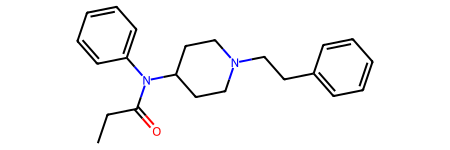

Generated molecules (noise std=0.3):


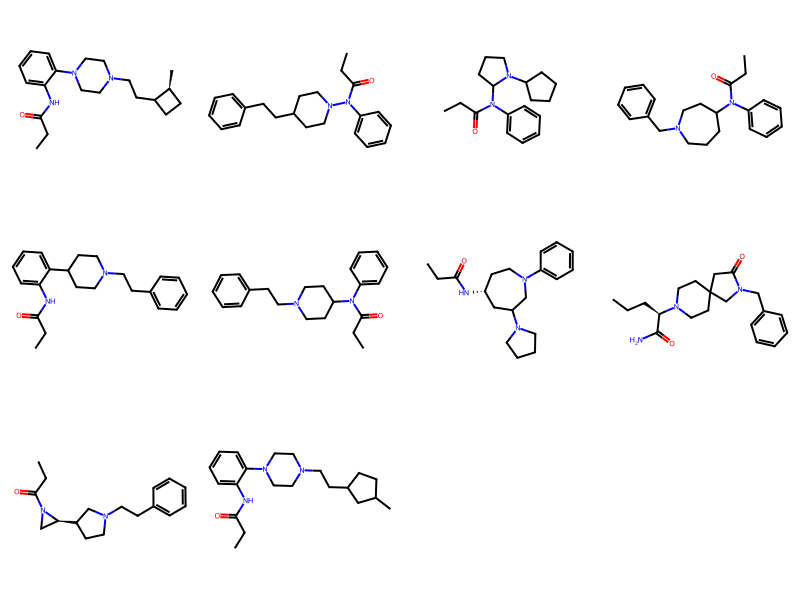

In [4]:
from coati.generative.coati_purifications import embed_smiles

# In this example, we use fentanyl as a reference molecule.
fentanyl_smiles = "CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3"
print("reference molecule:")
display(Chem.MolFromSmiles(fentanyl_smiles))

# We first convert the smiles to canonical smiles which is required by the model.
fentanyl_canonical_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(fentanyl_smiles))
# We then embed the canonical smiles to a 256D vector using the model.
fentanyl_vector = embed_smiles(fentanyl_canonical_smiles, encoder, tokenizer)

# We then generate 30 molecules near fentanyl. We do this by adding noise to the
# embedding vector which is then injected into the embed token in the prefix.
# The generated molecules are decoded back to smiles.
num_variations = 30
# noise is added as an isotropic Gaussian with std=noise_scale.
noise_scale = 0.3
smiles_near_fentanyl = encoder.hclip_to_2d_batch(
    h_clip=fentanyl_vector.unsqueeze(0).repeat(num_variations, 1),
    tokenizer=tokenizer,
    noise_scale=0.25,
)

# Visualize the generated molecules.
# Note that generated molecules are not guaranteed to be valid.
# Here we also use the set() function to remove duplicates.
print(f"Generated molecules (noise std={noise_scale}):")
display(
    Chem.Draw.MolsToGridImage(
        [
            Chem.MolFromSmiles(s)
            for s in set(smiles_near_fentanyl)
            if not Chem.MolFromSmiles(s) is None
        ],
        molsPerRow=4,
        useSVG=True,
    )
)

reference molecule:


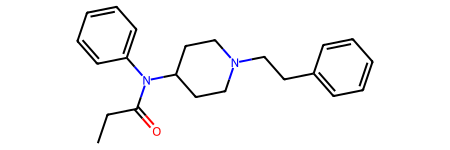

Generated molecules (noise std=0.2):


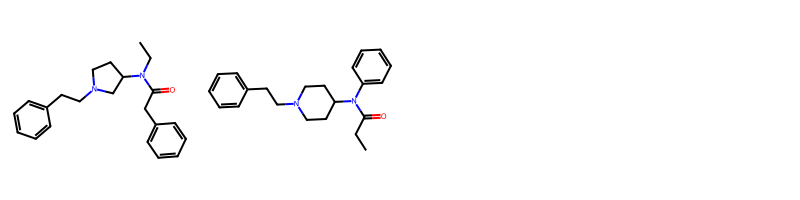

In [5]:
# We can reduce the noise to find molecules that are even closer to fentanyl.
num_variations = 30
noise_scale = 0.2
smiles_near_fentanyl = encoder.hclip_to_2d_batch(
    h_clip=fentanyl_vector.unsqueeze(0).repeat(num_variations, 1),
    tokenizer=tokenizer,
    noise_scale=noise_scale,
)

print("reference molecule:")
display(Chem.MolFromSmiles(fentanyl_smiles))
print(f"Generated molecules (noise std={noise_scale}):")
display(
    Chem.Draw.MolsToGridImage(
        [
            Chem.MolFromSmiles(s)
            for s in set(smiles_near_fentanyl)
            if not Chem.MolFromSmiles(s) is None
        ],
        molsPerRow=4,
        useSVG=True,
    )
)

Simple virtual screen by filtering.


Let's consider the properties: LogP and the quantitative estimate of druglikeness (QED) using the Chembl dataset.

In [6]:
from coati.common.s3 import cache_read

# load Chembl dataset smile strings.
with cache_read("s3://terray-public/datasets/chembl_canonical_smiles.pkl", "rb") as f:
    chembl_canonical_smiles = pickle.loads(f.read(), encoding="UTF-8")

# Use pretrained DUE models on QED and LogP calculated from RDKit on the Chembl
# dataset.
# For more info on the DUE model, see due_model_regression.ipynb
qed_model = torch.load("due_qed_june.pt").to(DEVICE)
logp_model = torch.load("due_logp_june.pt").to(DEVICE)

In [7]:
from coati.generative.coati_density import estimate_density_batchwise

# Fit a Gaussian to the embeddings of the Chembl dataset and use this
# distribution for sampling in the below virtual screen.
# The stopping criteria is given by the entropy of a batch of 1024 sample
# embeddings, i.e., maximum likelihood estimation.
fit_distribution = estimate_density_batchwise(
    chembl_canonical_smiles, encoder, tokenizer, batch_size=1024
)

entropy: 243.5833
entropy: 36.7543
entropy: 19.5350
entropy: 4.5723
entropy: -9.5142
entropy: -23.4296
entropy: -38.0915
entropy: -52.9080
entropy: -69.2543
entropy: -87.5103
entropy: -106.6741


In [8]:
from coati.generative.coati_purifications import force_decode_valid, embed_smiles


def sampled_virtual_screen(
    sample_maker,
    score_routine,
    encoder,
    tokenizer,
    log_functions=[],
    hit_thresh=1.5,
    n_to_draw=15,
    batch_size=512,
):
    """
    A simple example of a routine to write a filtered virtual screen.
    A threshold is set, samples are drawn, and those with predicted scores above
    the threshold are collected.
    """

    print("Finding molecules above threshold. [Smiles]: [score]")

    n_sampled = 0
    history = []
    with torch.no_grad():
        while len(history) < n_to_draw:
            vecs = sample_maker.rsample([batch_size])
            gvecs = vecs[score_routine(vecs) > hit_thresh, :]
            n_sampled += batch_size
            for gvec in gvecs:
                # retry decoding until we get a valid SMILES.
                smiles = force_decode_valid(gvec, encoder, tokenizer)
                emb = embed_smiles(smiles, encoder, tokenizer)
                score = score_routine(emb.unsqueeze(0)).detach().cpu().item()
                if score > hit_thresh:
                    print(f"{smiles}: {score:.2f}")
                    history.append(
                        {
                            "smiles": smiles,
                            "score": score,
                            **{
                                c: log_functions[c](emb).detach().cpu().item()
                                for c in log_functions
                            },
                        }
                    )
    print("sampled %d, found %d" % (n_sampled, len(history)))
    return history

In [9]:
from functools import partial


def extract_mean(v, model):
    return model(v).mean.to(v.device)


def extract_stddev(v, model):
    res = model(v.unsqueeze(0))
    return res.stddev.to(v.device)


# Scoring function for the virtual screen. Simply take the mean as reported by
# the DUE model.
logp_model_mean = partial(extract_mean, model=logp_model)

# Pull out samples with a logP above a threshold.
screen_results = sampled_virtual_screen(
    fit_distribution,
    logp_model_mean,
    encoder,
    tokenizer,
    hit_thresh=5.15,
    n_to_draw=10,
)

Finding molecules above threshold. [Smiles]: [score]
COc1ccc(/C=N/n2c(SCc3ccc(Cl)cc3Cl)nnc2C(=O)N2CCCC(C)C2)cc1: 5.78
CCOc1ccc(NCC2=C(c3cccs3)C(=O)N(Cc3cccs3)C2=O)cc1: 5.28
C[C@@H]1C[C@@H](NC(=O)c2nscc2-c2ccccc2)CCCN1c1cc(Cl)c(Cl)c([N+](=O)[O-])c1: 5.21
COc1ccc(CN(C)S(=O)(=O)c2ccccc2Nc2cnn(C(c3ccccc3)C3CCCCC3)c2C)cc1: 6.36
CNC(=O)c1cc(-c2ccccc2)nc2c(C)c(Cl)c(N3CCOC(C)C3)cc12: 5.68
CCN(CC)CCNc1ncnc2c1cc(C(=O)NCc1ccc(OC(C)C)cc1)n2Cc1ccccc1: 5.66
CCCC(Nc1ccccc1C=CC(=O)NC)c1ccc2c(c1)C(=O)N(C1CCN(Cc2ccccc2)C1=O)C2: 5.15
CCCC(Nc1ccc2nc(C=Cc3ccc(Cl)cc3)cc(C(=O)N(C)C)c2c1)C1CC1: 6.55
COc1ccccc1-n1nc(CCNc2csc(C(F)(F)F)c2)c2ccccc21: 5.46
CCCC(Nc1ccccc1C=CC(=O)NC)c1cc(F)cc(Cl)c1: 5.34
sampled 2048, found 10


Generated molecules: [predicted LogP] ([RDKit-calculated LogP])


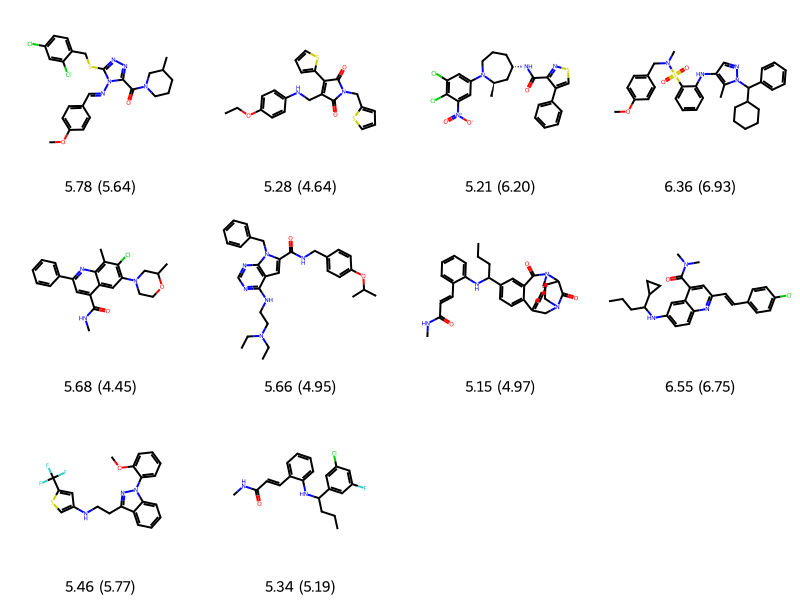

In [10]:
# For reference, calculate the LogP of the generated samples using RDKit.
screen_mols = [Chem.MolFromSmiles(row["smiles"]) for row in screen_results]
rdkit_scores = [rdkit.Chem.Crippen.MolLogP(m) for m in screen_mols]

# Visualize the results.
print("Generated molecules: [predicted LogP] ([RDKit-calculated LogP])")
legends = [f"{x['score']:.2f} ({y:.2f})" for x, y in zip(screen_results, rdkit_scores)]
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(s["smiles"]) for s in screen_results],
    molsPerRow=4,
    useSVG=True,
    legends=legends,
)

For more involved examples and visualization, see `examples/metadynamics`.